<a href="https://colab.research.google.com/github/FoxCoder-hub/BMC_Extractor/blob/main/P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importation des bibliothèques**

In [ ]:
# Pour dessiner Grantt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Pour gérer les listes
from collections import deque

### Definition du probleme

In [ ]:
str1 = "S*1*Atl1=Soudage*Atl2=Assemblage*Soudage=M1 M2*Assemblage=M3 M4*P*p=3"
str2 = "SumUi*di"
args = [[5,2,7,6],[4,2,1,3],[7,8,14,6],[3,8,4,1]]

prmtn = '0'
# Clean and split
elements_str1 = [x for x in str1.split('*') if x]
elements_str2 = [x.strip() for x in str2.split('*') if x.strip()]
elements_str21 = [x.strip() for x in elements_str2[1].split(',') if x.strip()]

# Compose the problem parts manually
machine_type = elements_str1[0] + elements_str1[1]  # 'F' + '2' → 'F2'
objective = elements_str2[0]  # 'Cmax'

# Final result
if len(elements_str2)==2:
  problem = [machine_type,elements_str2[1], objective]
else:
  problem = [machine_type, objective]

if problem[0] =='S1':
  problem[0]='1'

if 'prmtn' in elements_str21:
  prmtn='1'

print('args =', args)
print('problem =', problem)

# Extract parameters
if problem[0] == '1':  # Single machine case
    pi = args[0]  # Processing times (always first)
    n = len(pi)
    horizon = sum(pi)

    # Initialize parameter indices
    current_arg = 1  # Start after processing times

    # Release times (ri)
    if 'ri' in ''.join(problem):
        ri = args[current_arg] if len(args) > current_arg else [0]*n
        current_arg += 1
    else:
        ri = [0]*n

    # Deadlines (di)
    if 'di' in ''.join(problem):
        di = args[current_arg] if len(args) > current_arg else [sum(pi)]*n
        current_arg += 1
    else:
        di = [sum(pi)]*n

    # Weights (wi)
    if 'wi' in ''.join(problem):
        wi = args[current_arg] if len(args) > current_arg else [1]*n
        current_arg += 1
    else:
        wi = [1]*n

    # Precedence (prec)
    if 'prec' in ''.join(problem):
        precedence = args[current_arg] if len(args) > current_arg else []
    else:
        precedence = []
p=pi
print('pi =', p)
print('ri =', ri)
print('di =', di)
print('wi =', wi)
print('prec =', precedence)

args = [[5, 2, 7, 6], [4, 2, 1, 3], [7, 8, 14, 6], [3, 8, 4, 1]]
problem = ['1', 'di', 'SumUi']
pi = [5, 2, 7, 6]
ri = [0, 0, 0, 0]
di = [4, 2, 1, 3]
wi = [1, 1, 1, 1]
prec = []


### Fonction du probleme de type P

In [ ]:
# T: définir si le problème est de type P ou NP
T=True

def solve_scheduling_problem(problem, args, T):
    # Filter out empty arguments while preserving original indices
    non_empty_args = [arg for arg in args if arg != []]

    # Single machine problems (changed from 'U1' to '1' to match standard notation)
    if problem[0] == '1':
        if problem == ['1', 'Cmax']:
            p = args[0]
            sequence = list(range(len(p)))
            cmax = sum(p)
            print("Problem is P (1||Cmax)")
            return sequence, cmax

        elif problem == ['1', 'SumCi']:
            p = args[0]
            jobs = sorted(enumerate(p), key=lambda x: x[1])
            sequence = [j[0] for j in jobs]
            completion = 0
            total = 0
            for job in sequence:
                completion += p[job]
                total += completion
            print("Problem is P (1||ΣCi)")
            return sequence, total

        elif problem == ['1','wi','SumCi']:
            p = args[0]
            w = args[1]
            ratios = [wi/pi for pi, wi in zip(p, w)]
            jobs = sorted(enumerate(ratios), key=lambda x: -x[1])
            sequence = [j[0] for j in jobs]
            completion = 0
            total = 0
            for job in sequence:
                completion += p[job]
                total += w[job] * completion
            print("Problem is P (1||ΣwiCi)")
            return sequence, total

        elif problem == ['1', 'ri', 'Cmax']:
          p = args[0]
          r = args[1]
    # Tri des jobs par ri croissant (ERD)
          jobs = sorted(enumerate(zip(p, r)), key=lambda x: x[1][1])
          sequence = [j[0] for j in jobs]
          time = 0
          cmax = 0
          for job, (pj, rj) in jobs:
            time = max(time, rj)  # Attendre si nécessaire
            time += pj
            cmax = max(cmax, time)
          print("Problem is P (1|ri|Cmax)")
          return sequence, cmax

        elif problem == ['1', 'di', 'Lmax']:
            p = args[0]
            d = args[1]
            jobs = sorted(enumerate(d), key=lambda x: x[1])
            sequence = [j[0] for j in jobs]
            time = 0
            Lmax = -float('inf')
            for job in sequence:
                time += p[job]
                Lmax = max(Lmax, time - d[job])
            print("Problem is P (1|di|Lmax)")
            return sequence, Lmax

        elif problem == ['1', 'di,prmtn', 'Lmax']:
            p = args[0]
            d = args[1]
            jobs = sorted(enumerate(zip(p, d)), key=lambda x: x[1][1])
            schedule = []
            time = 0
            for job, (pj, dj) in jobs:
                schedule.append((job, time, time + pj))
                time += pj
            Lmax = max(end - d[job] for job, start, end in schedule)
            print("Problem is P (1|di,prmp|Lmax)")
            return [job for job,_,_ in schedule], Lmax

        elif problem == ['1', 'di', 'SumUi']:
          p = args[0]
          d = args[1]
          n = len(p)

    # Step 1: Sort jobs by due date
          jobs = sorted([(i, p[i], d[i]) for i in range(n)], key=lambda x: x[2])

          sequence = []
          time = 0
          late_jobs = []

          for i, pi, di in jobs:
            sequence.append((i, pi))
            time += pi

        # Check if current schedule is feasible
            if time > di:
              # Remove the job with the largest processing time
              max_p_job = max(sequence, key=lambda x: x[1])
              sequence.remove(max_p_job)
              time -= max_p_job[1]
              late_jobs.append(max_p_job[0])

    # Final sequence only includes on-time jobs
          final_sequence = [job for job, _ in sequence]
          num_late = len(late_jobs)

          print("Problem is P (1|di|ΣUi) - Solved using Moore's algorithm")
          return final_sequence, num_late


        elif problem == ['1', 'ri,di,prmtn', 'Lmax']:
            p = args[0]
            r = args[1]
            d = args[2]
            n = len(p)
            remaining = p.copy()
            time = 0
            schedule = []
            while sum(remaining) > 0:
                available = [j for j in range(n) if r[j] <= time and remaining[j] > 0]
                if not available:
                    time = min(r[j] for j in range(n) if remaining[j] > 0)
                    continue
                next_job = min(available, key=lambda j: d[j])
                schedule.append((next_job, time, time+1))
                remaining[next_job] -= 1
                time += 1
            completion = {j: max(t for job, s, t in schedule if job == j) for j in range(n)}
            Lmax = max(completion[j] - d[j] for j in range(n))
            print("Problem is P (1|ri,di,prmp|Lmax)")
            return schedule, Lmax

        elif problem == ['1', 'prec', 'Cmax']:
            p = args[0]
            predecessors = args[1]
            n = len(p)
            children = [[] for _ in range(n)]
            indegree = [0]*n
            for j in range(n):
                for pred in predecessors[j]:
                    children[pred].append(j)
                    indegree[j] += 1
            queue = deque(j for j in range(n) if indegree[j] == 0)
            order = []
            while queue:
                node = queue.popleft()
                order.append(node)
                for child in children[node]:
                    indegree[child] -= 1
                    if indegree[child] == 0:
                        queue.append(child)
            start = [0]*n
            for j in order:
                for child in children[j]:
                    start[child] = max(start[child], start[j] + p[j])
            cmax = max(start[j] + p[j] for j in range(n))
            print("Problem is P (1|prec|Cmax)")
            return order, cmax

    # Flow shop problems
    elif problem == ['F2', 'Cmax']:
          p1 = args[0]
          p2 = args[1]
          if len(p1) != len(p2):
              raise ValueError("p1 and p2 must have same length")

        # Johnson's algorithm
          group1 = [j for j in range(len(p1)) if p1[j] <= p2[j]]
          group2 = [j for j in range(len(p1)) if p1[j] > p2[j]]

          group1.sort(key=lambda j: p1[j])
          group2.sort(key=lambda j: -p2[j])

          sequence = group1 + group2

        # Calculate schedule for both machines
          time_m1 = 0
          time_m2 = 0
          schedule_m1 = []
          schedule_m2 = []

          for job in sequence:
            # Machine 1
            start_m1 = time_m1
            end_m1 = start_m1 + p1[job]
            schedule_m1.append((job, start_m1, end_m1))

            # Machine 2 starts when ready (after M1 and previous M2 tasks)
            start_m2 = max(end_m1, time_m2)
            end_m2 = start_m2 + p2[job]
            schedule_m2.append((job, start_m2, end_m2))

            time_m1 = end_m1
            time_m2 = end_m2

          cmax = time_m2
          print("Problem is P (F2||Cmax)")
          return [schedule_m1, schedule_m2], cmax  # Return both machine schedules


    # Parallel machine problems
    elif problem[0].startswith('P') and problem[0][1:].isdigit() and problem[1] == 'SumCi':
        p = args[0]
        m = int(problem[0][1:])  # Get number of machines from problem string
        jobs = sorted(enumerate(p), key=lambda x: x[1])
        machine_times = [0]*m
        machine_jobs = [[] for _ in range(m)]
        total = 0
        for job, pj in jobs:
            machine = min(range(m), key=lambda i: machine_times[i])
            machine_jobs[machine].append(job)
            machine_times[machine] += pj
            total += machine_times[machine]
        print(f"Problem is P (P{m}||ΣCi)")
        return machine_jobs, total

    elif (problem[0].startswith('P') and problem[0][1:].isdigit() and
      len(problem) == 3 and problem[1] == 'prmtn' and problem[2] == 'Cmax'):
      p = args[0]
      m = int(problem[0][1:])
      cmax = max(max(p), sum(p)/m)
      schedules = [[] for _ in range(m)]
      current_pos = [0.0] * m
      for j, pj in enumerate(p):
        remaining = pj
        while remaining > 0:
            machine = min(range(m), key=lambda x: current_pos[x])
            available = cmax - current_pos[machine]
            allocate = min(available, remaining)
            schedules[machine].append((j, current_pos[machine], current_pos[machine] + allocate))
            current_pos[machine] += allocate
            remaining -= allocate
      print(f"Problem is P (P{m}|prmp|Cmax)")
      return schedules, cmax

    # Open shop problems

    elif problem == ['O2', 'Cmax']:
        p1 = args[0]  # Times on M1
        p2 = args[1]  # Times on M2
        n = len(p1)

        # Step 1: Compute optimal Cmax
        total_p1 = sum(p1)
        total_p2 = sum(p2)
        max_job_time = max(p1[i] + p2[i] for i in range(n))
        cmax = max(total_p1, total_p2, max_job_time)

        # Step 2: Initialize availability grids
        time_m1 = [0] * cmax  # 0 = free, 1 = busy
        time_m2 = [0] * cmax

        schedule_m1 = []
        schedule_m2 = []

        # Step 3: Sort jobs by descending total processing time
        jobs = sorted(range(n), key=lambda j: -(p1[j] + p2[j]))

        for j in jobs:
            len1, len2 = p1[j], p2[j]
            assigned = False

            for t1 in range(cmax - len1 + 1):
                if any(time_m1[t1 + k] for k in range(len1)):
                    continue  # Machine 1 busy

                for t2 in range(cmax - len2 + 1):
                    if any(time_m2[t2 + k] for k in range(len2)):
                        continue  # Machine 2 busy

                    if t1 + len1 <= t2 or t2 + len2 <= t1:
                        # No overlap of job j across both machines
                        for k in range(len1):
                            time_m1[t1 + k] = 1
                        for k in range(len2):
                            time_m2[t2 + k] = 1

                        schedule_m1.append((j, t1, t1 + len1))
                        schedule_m2.append((j, t2, t2 + len2))
                        assigned = True
                        break
                if assigned:
                    break

        print("Problem is P (O2||Cmax) - Solved optimally using Gonzalez–Sahni")
        return [schedule_m1, schedule_m2], cmax


    #job shop
    elif problem == ['J2', 'Cmax']:
      p1 = args[0]  # processing times on Machine 1
      p2 = args[1]  # processing times on Machine 2
      n = len(p1)

    # According to Jackson's rule:
    # Group A: jobs where p1 <= p2
    # Group B: jobs where p1 > p2

      group_A = [j for j in range(n) if p1[j] <= p2[j]]
      group_B = [j for j in range(n) if p1[j] > p2[j]]

    # Sort group A by ascending p1
      group_A.sort(key=lambda j: p1[j])
    # Sort group B by descending p2
      group_B.sort(key=lambda j: -p2[j])

      sequence = group_A + group_B

    # Build schedule
      schedule = [[] for _ in range(2)]  # 2 machines
      end_times = [0, 0]  # end times on machines 1 and 2

      for job in sequence:
        # Schedule on Machine 1
        start1 = end_times[0]
        end1 = start1 + p1[job]
        schedule[0].append((job, start1, end1))
        end_times[0] = end1

        # Schedule on Machine 2 (starts after job finishes on M1 and after M2 is free)
        start2 = max(end1, end_times[1])
        end2 = start2 + p2[job]
        schedule[1].append((job, start2, end2))
        end_times[1] = end2

      cmax = max(end_times)
      print("Résolution J2||Cmax avec Jackson")
      return schedule, cmax


    else:
        print("Problème non reconnu")
        return None, False

## Normailsation

Problem is P (1|di|ΣUi) - Solved using Moore's algorithm
Solution: [1] 3
Séquence = [1]
Valeur optimale = 3


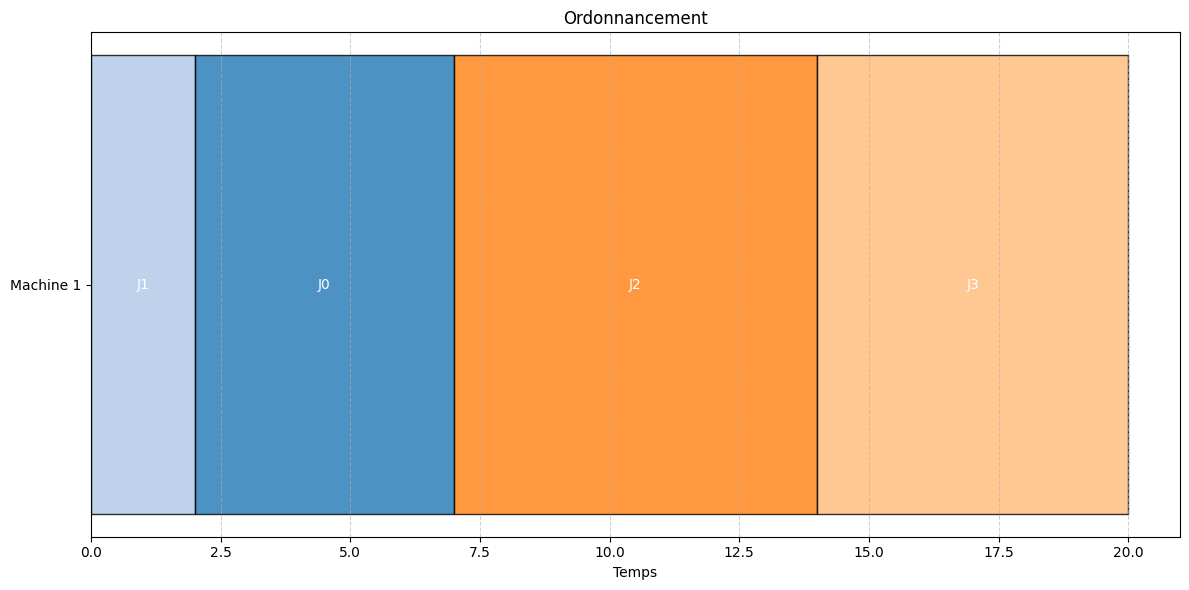

In [ ]:
#Diagramme de Grantt
def normalize_result_for_gantt(result, problem, args):
    if result is None:
        return []

    # Get processing times
    p = args[0]
    n = len(p)

    # Case 1: Already in machine-wise interval format
    if isinstance(result, list) and result and isinstance(result[0], list) and result[0] and isinstance(result[0][0], tuple):
        return result

    # Case 2: Single machine with intervals
    if isinstance(result, list) and result and isinstance(result[0], tuple):
        return [result]

    # Case 3: Job sequence (list of job indices) - including SumUi case
    if isinstance(result, list) and result and isinstance(result[0], int):
        schedule = []
        time = 0

        # Handle SumUi case where some jobs may be missing from sequence
        if 'SumUi' in problem and len(result) < n:
            schedule = []
            time = 0
            scheduled_jobs = set(result)

    # 1. Add scheduled (on-time) jobs first
            for job in result:
              start_time = time
              end_time = start_time + p[job]
              schedule.append((job, start_time, end_time))
              time = end_time

    # 2. Then add late jobs after on-time ones
            for job in range(len(p)):
              if job not in scheduled_jobs:
                start_time = time
                end_time = start_time + p[job]
                schedule.append((job, start_time, end_time))
                time = end_time

            return [schedule]

        # Original handling for other cases
        # Check for release time constraint
        has_ri = 'ri' in problem
        r = args[1] if has_ri and len(args) > 1 else [0]*n

        # Check for precedence constraints
        has_prec = 'prec' in problem
        predecessors = args[1] if has_prec and len(args) > 1 else []

        for job in result:
            # Apply release time constraint
            start_time = max(time, r[job]) if has_ri else time

            # Apply precedence constraints if any
            if has_prec and predecessors:
                latest_predecessor = 0
                for pred in predecessors[job]:
                    # Find completion time of predecessor
                    for task in schedule:
                        if task[0] == pred:
                            latest_predecessor = max(latest_predecessor, task[2])
                            break
                start_time = max(start_time, latest_predecessor)

            end_time = start_time + p[job]
            schedule.append((job, start_time, end_time))
            time = end_time

        return [schedule]

    # Case 4: Parallel machine assignments
    if isinstance(result, list) and result and isinstance(result[0], list):
        p = args[0]
        schedules = []

        # Check for release time constraint
        has_ri = 'ri' in problem
        r = args[1] if has_ri and len(args) > 1 else [0]*len(p)

        for machine_jobs in result:
            machine_schedule = []
            time = 0
            for job in machine_jobs:
                start_time = max(time, r[job]) if has_ri else time
                end_time = start_time + p[job]
                machine_schedule.append((job, start_time, end_time))
                time = end_time
            schedules.append(machine_schedule)

        return schedules

    return []


def afficher_gantt(schedules, title="Ordonnancement"):

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.tab20.colors

    for machine_id, schedule in enumerate(schedules):
        for task in schedule:
            job_id, start, end = task
            duration = end - start
            ax.barh(machine_id, duration, left=start,
                   color=colors[job_id % len(colors)],
                   edgecolor='black', alpha=0.8)
            ax.text(start + duration/2, machine_id, f'J{job_id}',
                   ha='center', va='center', color='white')

    ax.set_yticks(range(len(schedules)))
    ax.set_yticklabels([f"Machine {i+1}" for i in range(len(schedules))])
    ax.set_xlabel("Temps")
    ax.set_title(title)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

output = solve_scheduling_problem(problem, args, T)
if output is None:  # Still got None? Something is wrong inside the function
    print("ERROR: Function returned None unexpectedly!")
elif output == (None, False):  # Problem not recognized
    print("No solution (problem not recognized)")
else:
    result, value = output
    print('Solution:', result, value)
    print('Séquence =', result)
    print('Valeur optimale =', value)
    normalized_result = normalize_result_for_gantt(result, problem, args)
    afficher_gantt(normalized_result, title="Ordonnancement")

### Main

In [ ]:
from collections import defaultdict

def solve_scheduling_problem(problem, args):
    """Résout un problème d'ordonnancement avec une heuristique adaptative BS"""

    # Vérification du type de problème
    if is_polynomial(problem):
        return solve_exact(problem, args)
    else:
        return solve_heuristic_BS(problem, args)

def is_polynomial(problem):
    """Détermine si le problème est de classe P (à compléter selon besoins)"""
    known_p_problems = {
        ('1', 'Cmax'), ('1', 'SumCi'), ('1', 'di', 'Lmax'),
        ('F2', 'Cmax'), ('P2', 'Cmax'), ('1', 'ri', 'prec', 'Cmax')
    }
    return tuple(problem) in known_p_problems

def solve_exact(problem, args):
    """Solution exacte pour les problèmes P (implémentation simplifiée)"""
    return {"method": "Exact solution", "details": "Not implemented in this generic version"}



**Old Version**

In [ ]:
# T: définir si le problème est de type P ou NP
T=True

def solve_scheduling_problem(problem, args, T):
    # Filter out empty arguments while preserving original indices
    non_empty_args = [arg for arg in args if arg != []]

    # Single machine problems (changed from 'U1' to '1' to match standard notation)
    if problem[0] == '1':
        if problem == ['1', 'Cmax']:
            p = args[0]
            sequence = list(range(len(p)))
            cmax = sum(p)
            print("Problem is P (1||Cmax)")
            return sequence, cmax

        elif problem == ['1', 'SumCi']:
            p = args[0]
            jobs = sorted(enumerate(p), key=lambda x: x[1])
            sequence = [j[0] for j in jobs]
            completion = 0
            total = 0
            for job in sequence:
                completion += p[job]
                total += completion
            print("Problem is P (1||ΣCi)")
            return sequence, total

        elif problem == ['1','wi','SumCi']:
            p = args[0]
            w = args[1]
            ratios = [wi/pi for pi, wi in zip(p, w)]
            jobs = sorted(enumerate(ratios), key=lambda x: -x[1])
            sequence = [j[0] for j in jobs]
            completion = 0
            total = 0
            for job in sequence:
                completion += p[job]
                total += w[job] * completion
            print("Problem is P (1||ΣwiCi)")
            return sequence, total

        elif problem == ['1', 'ri', 'Cmax']:
          p = args[0]
          r = args[1]
    # Tri des jobs par ri croissant (ERD)
          jobs = sorted(enumerate(zip(p, r)), key=lambda x: x[1][1])
          sequence = [j[0] for j in jobs]
          time = 0
          cmax = 0
          for job, (pj, rj) in jobs:
            time = max(time, rj)  # Attendre si nécessaire
            time += pj
            cmax = max(cmax, time)
          print("Problem is P (1|ri|Cmax)")
          return sequence, cmax

        elif problem == ['1', 'di', 'Lmax']:
            p = args[0]
            d = args[1]
            jobs = sorted(enumerate(d), key=lambda x: x[1])
            sequence = [j[0] for j in jobs]
            time = 0
            Lmax = -float('inf')
            for job in sequence:
                time += p[job]
                Lmax = max(Lmax, time - d[job])
            print("Problem is P (1|di|Lmax)")
            return sequence, Lmax

        elif problem == ['1', 'di,prmtn', 'Lmax']:
            p = args[0]
            d = args[1]
            jobs = sorted(enumerate(zip(p, d)), key=lambda x: x[1][1])
            schedule = []
            time = 0
            for job, (pj, dj) in jobs:
                schedule.append((job, time, time + pj))
                time += pj
            Lmax = max(end - d[job] for job, start, end in schedule)
            print("Problem is P (1|di,prmp|Lmax)")
            return [job for job,_,_ in schedule], Lmax

        elif problem == ['1', 'di', 'SumUi']:
            p = args[0]
            d = args[1]
            jobs = sorted(enumerate(zip(p, d)), key=lambda x: x[1][1])
            sequence = []
            current_time = 0
            late = 0
            for job, (pj, dj) in jobs:
                if current_time + pj <= dj:
                    sequence.append(job)
                    current_time += pj
                else:
                    late += 1
            print("Problem is P (1|di|ΣUi)")
            return sequence, late

        elif problem == ['1', 'ri,di,prmtn', 'Lmax']:
            p = args[0]
            r = args[1]
            d = args[2]
            n = len(p)
            remaining = p.copy()
            time = 0
            schedule = []
            while sum(remaining) > 0:
                available = [j for j in range(n) if r[j] <= time and remaining[j] > 0]
                if not available:
                    time = min(r[j] for j in range(n) if remaining[j] > 0)
                    continue
                next_job = min(available, key=lambda j: d[j])
                schedule.append((next_job, time, time+1))
                remaining[next_job] -= 1
                time += 1
            completion = {j: max(t for job, s, t in schedule if job == j) for j in range(n)}
            Lmax = max(completion[j] - d[j] for j in range(n))
            print("Problem is P (1|ri,di,prmp|Lmax)")
            return schedule, Lmax

        elif problem == ['1', 'prec', 'Cmax']:
            p = args[0]
            predecessors = args[1]
            n = len(p)
            children = [[] for _ in range(n)]
            indegree = [0]*n
            for j in range(n):
                for pred in predecessors[j]:
                    children[pred].append(j)
                    indegree[j] += 1
            queue = deque(j for j in range(n) if indegree[j] == 0)
            order = []
            while queue:
                node = queue.popleft()
                order.append(node)
                for child in children[node]:
                    indegree[child] -= 1
                    if indegree[child] == 0:
                        queue.append(child)
            start = [0]*n
            for j in order:
                for child in children[j]:
                    start[child] = max(start[child], start[j] + p[j])
            cmax = max(start[j] + p[j] for j in range(n))
            print("Problem is P (1|prec|Cmax)")
            return order, cmax

    # Flow shop problems
    elif problem == ['F2', 'Cmax']:
          p1 = args[0]
          p2 = args[1]
          if len(p1) != len(p2):
              raise ValueError("p1 and p2 must have same length")

        # Johnson's algorithm
          group1 = [j for j in range(len(p1)) if p1[j] <= p2[j]]
          group2 = [j for j in range(len(p1)) if p1[j] > p2[j]]

          group1.sort(key=lambda j: p1[j])
          group2.sort(key=lambda j: -p2[j])

          sequence = group1 + group2

        # Calculate schedule for both machines
          time_m1 = 0
          time_m2 = 0
          schedule_m1 = []
          schedule_m2 = []

          for job in sequence:
            # Machine 1
            start_m1 = time_m1
            end_m1 = start_m1 + p1[job]
            schedule_m1.append((job, start_m1, end_m1))

            # Machine 2 starts when ready (after M1 and previous M2 tasks)
            start_m2 = max(end_m1, time_m2)
            end_m2 = start_m2 + p2[job]
            schedule_m2.append((job, start_m2, end_m2))

            time_m1 = end_m1
            time_m2 = end_m2

          cmax = time_m2
          print("Problem is P (F2||Cmax)")
          return [schedule_m1, schedule_m2], cmax  # Return both machine schedules


    # Parallel machine problems
    elif problem[0].startswith('P') and problem[0][1:].isdigit() and problem[1] == 'SumCi':
        p = args[0]
        m = int(problem[0][1:])  # Get number of machines from problem string
        jobs = sorted(enumerate(p), key=lambda x: x[1])
        machine_times = [0]*m
        machine_jobs = [[] for _ in range(m)]
        total = 0
        for job, pj in jobs:
            machine = min(range(m), key=lambda i: machine_times[i])
            machine_jobs[machine].append(job)
            machine_times[machine] += pj
            total += machine_times[machine]
        print(f"Problem is P (P{m}||ΣCi)")
        return machine_jobs, total

    elif (problem[0].startswith('P') and problem[0][1:].isdigit() and
      len(problem) == 3 and problem[1] == 'prmtn' and problem[2] == 'Cmax'):
      p = args[0]
      m = int(problem[0][1:])
      cmax = max(max(p), sum(p)/m)
      schedules = [[] for _ in range(m)]
      current_pos = [0.0] * m
      for j, pj in enumerate(p):
        remaining = pj
        while remaining > 0:
            machine = min(range(m), key=lambda x: current_pos[x])
            available = cmax - current_pos[machine]
            allocate = min(available, remaining)
            schedules[machine].append((j, current_pos[machine], current_pos[machine] + allocate))
            current_pos[machine] += allocate
            remaining -= allocate
      print(f"Problem is P (P{m}|prmp|Cmax)")
      return schedules, cmax

    # Open shop problems

    elif problem == ['O2', 'Cmax']:
      p1 = args[0]  # Times on M1
      p2 = args[1]  # Times on M2
      operations = list(zip(p1, p2))

    # Generate machine sequences
      m1_seq = []
      m2_seq = []
      for job, (a, b) in enumerate(operations):
        if a <= b:
            m1_seq.append(job)
            m2_seq.insert(0, job)
        else:
            m2_seq.append(job)
            m1_seq.insert(0, job)

    # Calculate schedules with time intervals
      def build_schedule(sequence, processing_times):
        schedule = []
        time = 0
        for job in sequence:
            start = time
            end = start + processing_times[job]
            schedule.append((job, start, end))
            time = end
        return schedule

      schedule_m1 = build_schedule(m1_seq, p1)
      schedule_m2 = build_schedule(m2_seq, p2)

    # Calculate cmax
      cmax = max(
        sum(p1),
        sum(p2),
        max(a + b for a, b in operations)
     )

      print("Problem is P (O2||Cmax)")
      return [schedule_m1, schedule_m2], cmax  # Return schedules with time intervals

    #job shop
    elif problem == ['J2', 'Cmax']:
      p1 = args[0]  # processing times on Machine 1
      p2 = args[1]  # processing times on Machine 2
      n = len(p1)

    # According to Jackson's rule:
    # Group A: jobs where p1 <= p2
    # Group B: jobs where p1 > p2

      group_A = [j for j in range(n) if p1[j] <= p2[j]]
      group_B = [j for j in range(n) if p1[j] > p2[j]]

    # Sort group A by ascending p1
      group_A.sort(key=lambda j: p1[j])
    # Sort group B by descending p2
      group_B.sort(key=lambda j: -p2[j])

      sequence = group_A + group_B

    # Build schedule
      schedule = [[] for _ in range(2)]  # 2 machines
      end_times = [0, 0]  # end times on machines 1 and 2

      for job in sequence:
        # Schedule on Machine 1
        start1 = end_times[0]
        end1 = start1 + p1[job]
        schedule[0].append((job, start1, end1))
        end_times[0] = end1

        # Schedule on Machine 2 (starts after job finishes on M1 and after M2 is free)
        start2 = max(end1, end_times[1])
        end2 = start2 + p2[job]
        schedule[1].append((job, start2, end2))
        end_times[1] = end2

      cmax = max(end_times)
      print("Résolution J2||Cmax avec Jackson")
      return schedule, cmax


    else:
        print("Problème non reconnu")
        return None, False